This code is used to generate the final figure of the paper "Towards Dynamic Algorithm Selection for Numerical Black-Box Optimization"
The first cell sets up the experimentation run, the second runs the data collection needed. This is then transformed into a dataframe, on which the visualization is done.
Note: this code only works when the 'dynas' folder is at the same level as this notebook, otherwise the imports in the first cell shoudl be modified

In [1]:
from dynas.algorithm import Switching_algorithm
from itertools import product
from functools import partial
import sys
import argparse
import warnings
from dynas.bfgs import BFGS
from dynas.pso import PSO
from dynas.cmaes import CMAES
from dynas.mlsl import MLSL
from dynas.de import DE
import numpy as np
import pickle
from multiprocessing import cpu_count
from multiprocessing import Pool
from pathlib import Path
from IOHexperimenter import IOH_function

_supported_classes = [MLSL, DE, PSO, CMAES, BFGS]
_used_classes = [BFGS, CMAES]
powers = np.round(np.linspace(2, -8, 51), decimals=1)
_splits = np.power([10]*51, powers)

from ioh import problem, logger

ioh_dir = "/mnt/d/Research/algswitch/Data_Split"
# pkl_dir = "/mnt/d/Research/algswitch/Data_Split/PKL"

def runParallelFunction(runFunction, arguments):
    """
        Return the output of runFunction for each set of arguments,
        making use of as much parallelization as possible on this system

        :param runFunction: The function that can be executed in parallel
        :param arguments:   List of tuples, where each tuple are the arguments
                            to pass to the function
        :return:
    """
    

    arguments = list(arguments)
    p = Pool(min(cpu_count(), len(arguments)))
#     local_func = partial(func_star, func=runFunction)
    results = p.map(runFunction, arguments)
    p.close()
    return results

In [5]:
records = []
fid = 14
dim = 20
for iid in range(5):
    for a1 in _used_classes:
        for a2 in _used_classes:
            if a1 != a2:
                for sp in _splits:
                    np.random.seed(42)
                    #                 if Path(f"{ioh_dir}/F{fid}_{dim}D_I{iid}_{a1.__name__}_{s}_{a2.__name__}").exists():
                    #                     next
                    if sp == _splits[-1]:
                        config = {sp : {'class' : a1, 'hyperparams' : {}}}
                    else:
                        config = {sp : {'class' : a1, 'hyperparams' : {}}, 1e-8 : {'class' : a2, 'hyperparams' : {}}}
                    f = IOH_function(fid, dim=dim, iid=iid)
                    #         problem.Real.factory().create(fid, iid, dim) #problem. (1,5,5, budget=50000)
    #                 l = logger.Default(f"{ioh_dir}/F{fid}_{dim}D_I{iid}_{a1.__name__}_{s}_{a2.__name__}", store_positions=False, algorithm_name=f"{a1.__name__}_{s}_{a2.__name__}")
    #                 f.attach_logger(l)
                    for repnr in range(5):
                        s = Switching_algorithm(f, config, seed = repnr, verbose = False, fixed_target=True)
                        res = s()
                        records.append([a1.__name__, a2.__name__, sp, fid, dim, iid, f.evaluations, f.best_so_far_precision])
                        #                     res_relevant = res['CMA_state_vars_1']
                        #                     with open(f"{pkl_dir}/F{fid}_{dim}D_I{iid}_{a2.__name__}_r{repnr}.pkl", 'wb') as fileobj:
                        #                         pickle.dump(res_relevant, fileobj)
                        f.reset()
    #                 l.flush()


In [6]:
import pandas as pd

In [7]:
dt= pd.DataFrame.from_records(records, columns = ['A1', 'A2', 'Splitpoint', 'fid', 'dim', 'iid', 'HT', 'Precision'])

In [8]:
import matplotlib.pyplot as plt
import seaborn as sbs

In [9]:
dt['idx'] = [int(x) for x in ((5*np.log10(dt['Splitpoint']))+40)]

In [10]:
dt['adj_HT'] = [x if y<=1e-8 else 50000 for (x,y) in zip(dt['HT'], dt['Precision'])]

In [30]:
dt_sub = dt[(dt['A1'] == 'BFGS') & (dt['Splitpoint'] > 1e-8)]

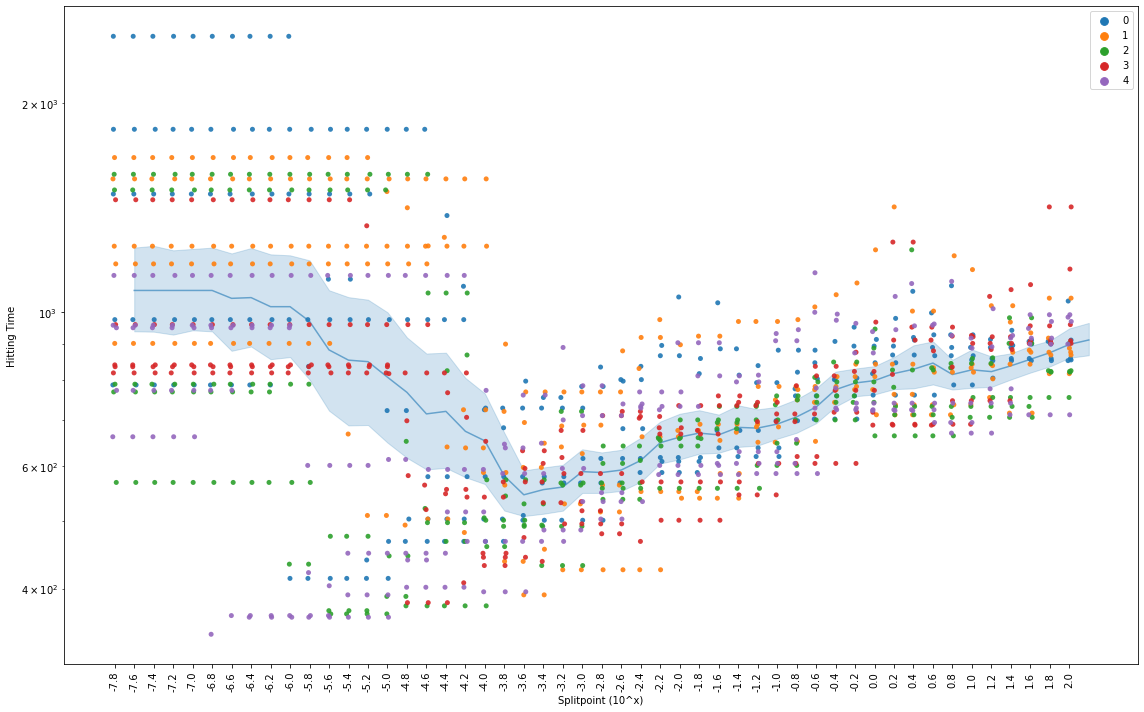

In [34]:
# dt_plot = dt[dt['A1'] == 'BFGS']

plt.figure(figsize=(16,10))
# sbs.boxplot(data=dt, x='Splitpoint', y='HT', hue='A1')
sbs.stripplot(data=dt_sub, x='Splitpoint', y='adj_HT', alpha=0.9, hue='iid')
sbs.lineplot(data=dt_sub, x='idx', y='adj_HT', alpha=0.6, estimator=lambda x: np.exp(np.mean(np.log(x))))
plt.xticks(range(50),np.flip(powers[:-1]),rotation=90)
plt.yscale("log")
plt.ylabel("Hitting Time")
plt.xlabel("Splitpoint (10^x)")
plt.tight_layout()
plt.savefig(f"Figures/F{fid}_{dim}D_splitpoint_location_difference_v3.pdf")